# Домашнее задание
С вашим датасетом нужно проделать примерно то же самое, что мы делали с примером "12-6. Оценка стоимости квартиры.ipynb" Обратите внимание, что у вас - может быть задача классификации, а мы решали задачу регрессии  (также можно посмотреть 19-02. Adult.ipynb, где решается задача классификации) (https://github.com/NikolaiZolotykh/MachineLearningCourse). Все должно быть выложено на ваш гит.

А именно:
0. Описать задачу словами
1. Прочитать данные
2. Визуализировать данные и вычислить основные характеристики (среднее, разброс, корреляционную матрицу и т.д.). Интерпретировать.
3. Обработать пропущенные значения (или убедиться, что их нет)
4. Обработать категориальные признаки
5. Провести нормализацию (или объяснить, почему в вашем случае она не нужна)
6. Разбить данные на обучающую и тестовую выборки
7. Запустить классификатор (регрессию) ближайших соседей или другой (аргументировать свой выбор)
8. Подобрать оптимальное значение к-ва ближайших соседей (или другого релевантного гиперпараметра)
9. Вычислить ошибки на обучающей и тестовой выборках. Сделать выводы 
10. Запустить другие классификаторы и выбать параметры. Выбрать релевантные! Сравнить результаты
11. как-то побороться с несбалансированностью классов (если она есть)
12. исключить коррелированные переменные (объяснить зачем)
13. Сделать общие выводы

## 0. Описание задачи
Задача: Классификация различных типов ритмов сердца (нозологий) на основе набора данных, содержащего
параметры, описывающие работу сердечно-сосудистой системы. Цель — создать модель, которая сможет 
правильно классифицировать различные состояния ритма сердца.

Набор данных:
- Файл three_bases_meta.csv содержит метаданные с описанием признаков.
- Файлы three_bases_X.npy и three_bases_Y.npy содержат признаки и целевые классы для задачи.

## 1. Импорт библиотек и загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

Метаданные:

+--------------+------+--------+-------------------------------+----------------------+--------------------------+
| Record index | Age  | Gender | Patient ID in source database | Source database name | Index in source database |
+--------------+------+--------+-------------------------------+----------------------+--------------------------+
|      0       | 56.0 |  0.0   |            15709.0            |        ptb_xl        |            1             |
|      1       | 19.0 |  1.0   |            13243.0            |        ptb_xl        |            2             |
|      2       | 37.0 |  0.0   |            20372.0            |        ptb_xl        |            3             |
|      3       | 24.0 |  1.0   |            17014.0            |        ptb_xl        |            4             |
|      4       | 19.0 |  0.0   |            17448.0            |        ptb_xl        |            5             |
+--------------+------+--------+-------------------------------+---

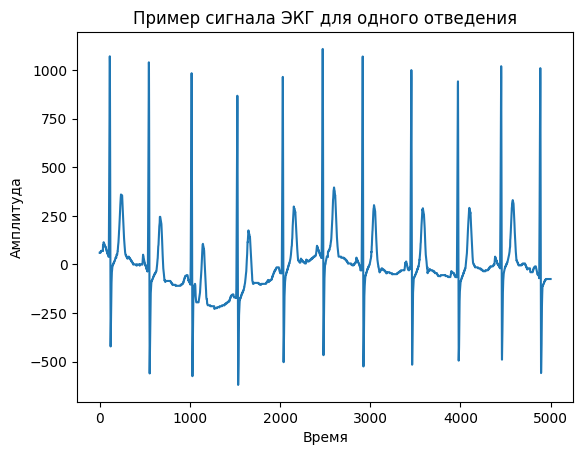

77243
1
                                             Нозология  Значение
                                        Синусовый ритм      True
                                  Синусовая тахикардия     False
                                 Синусовая брадикардия      True
                                     Синусовая аритмия     False
                                      Предсердный ритм     False
                                          Узловой ритм     False
                                Фибрилляция предсердий     False
Трепетание предсердий: правильная и неправильная форма     False
                        Наджелудочковая экстрасистолия     False
                           Желудочковая экстрасистолия     False
                   Тахикардия с узкими комплексами QRS     False
                 Тахикардия с широкими комплексами QRS     False
                                      АВ-блокада I ст.     False
                              АВ-блокада II ст. 1 тип.     False
                 

In [11]:
# Загрузка данных
# Описание признаков
meta = pd.read_csv('/home/dbulgakov/ml/lectures/data/three_bases_meta.csv')
# Массив признаков
X = np.load('/home/dbulgakov/ml/lectures/data/three_bases_X.npy', mmap_mode='r')
# Целевые классы (типы ритмов сердца)
y = np.load('/home/dbulgakov/ml/lectures/data/three_bases_Y.npy')

# Просмотр первых строк метаданных
from tabulate import tabulate

print("Метаданные:\n")
print(tabulate(meta.head().reset_index(drop=True), headers='keys', tablefmt='pretty', showindex=False))

print("\nРазмер данных X:", X.shape)
print("Размер данных y:", y.shape)

unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Частота классов в y:", class_counts)

print(X[0])

print(y[0])

plt.plot(X[1111][9])  # Сигнал первого отведения первой записи
plt.title("Пример сигнала ЭКГ для одного отведения")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.show()

import pandas as pd

# Список нозологий
nosologies = [
    "Синусовый ритм",
    "Синусовая тахикардия",
    "Синусовая брадикардия",
    "Синусовая аритмия",
    "Предсердный ритм",
    "Узловой ритм",
    "Фибрилляция предсердий",
    "Трепетание предсердий: правильная и неправильная форма",
    "Наджелудочковая экстрасистолия",
    "Желудочковая экстрасистолия",
    "Тахикардия с узкими комплексами QRS",
    "Тахикардия с широкими комплексами QRS",
    "АВ-блокада I ст.",
    "АВ-блокада II ст. 1 тип.",
    "АВ-блокада II ст. 2 тип.",
    "АВ-блокада III ст.",
    "Уширение комплекса QRS, требующее верификации",
    "Синдром короткого интервала PQ",
    "Синдром удлиненного интервала QT",
    "Синдром короткого интервала QT"
]

# Создаем DataFrame с результатами
df = pd.DataFrame({
    "Нозология": nosologies,
    "Значение": y[1]
})

for i in range(len(y)):
    if y[i].sum() > 1:
        print(i)
        break

# Печатаем таблицу
print(df.to_string(index=False))



In [3]:
# Для анализа возьмем только часть данных
start=0
end=10000
X = X[start:end]
y = y[start:end]
meta = meta[start:end]

## 2. Визуализация данных и вычисление основных характеристик

Средние значения по каналам: [-0.91830006 -0.90932214  0.00852508  0.8985638  -0.41277784 -0.43008598
  0.65183864 -0.83213436 -1.55217944 -2.45785094 -1.0249356  -1.10532682]
Дисперсия (разброс) по каналам: [ 25068.83833798  28700.63986679  25966.1741376   20397.27083242
  18341.28881053  21027.12231167  56378.22576415 112020.56742393
 110271.75843495 104097.64500826  75012.17288634  63330.60226648]


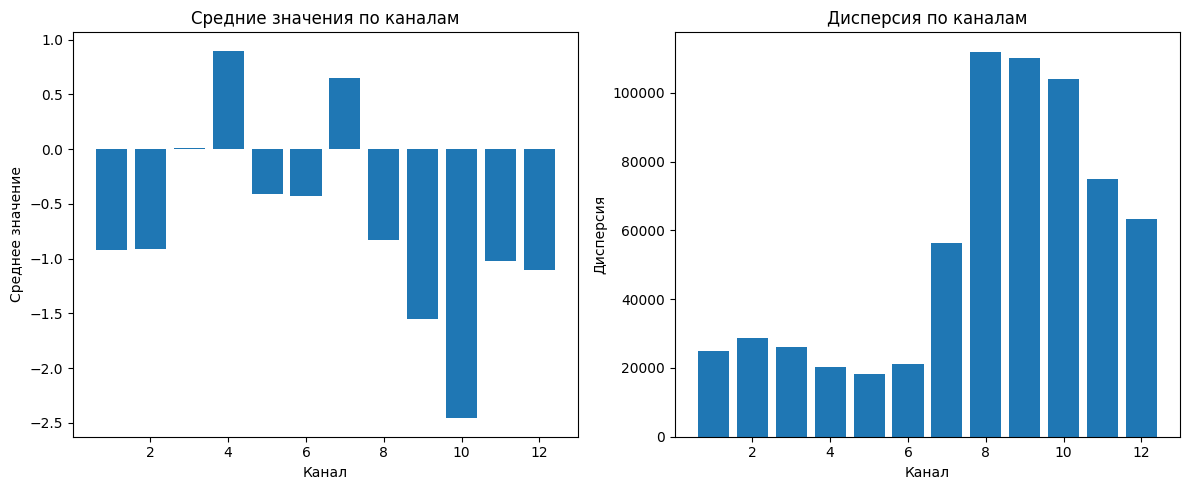

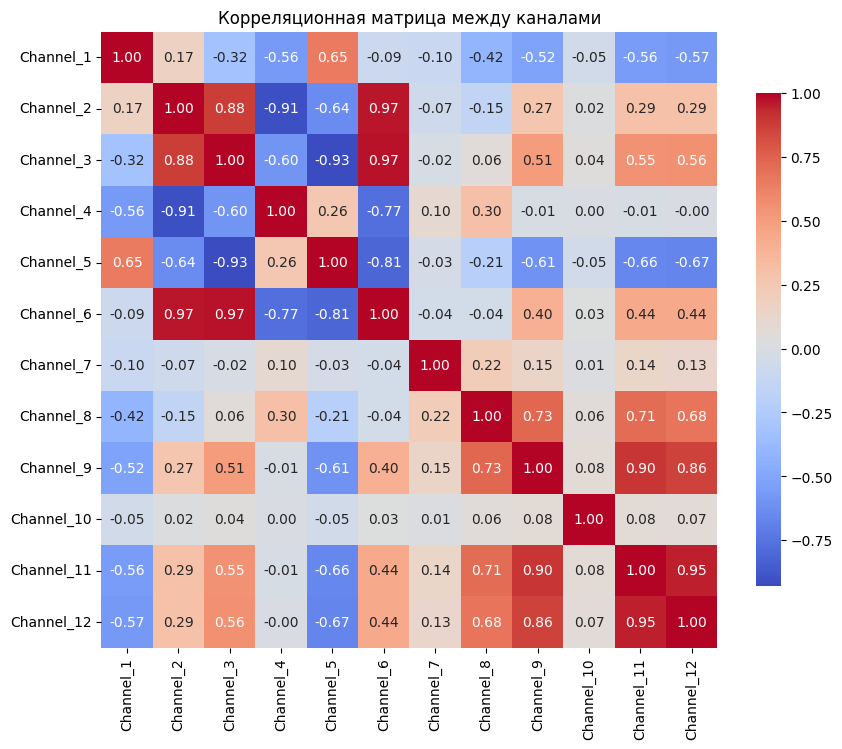

Медианы по каналам: [-25. -22.   5.  25. -13.  -6.  21.   0. -20. -35. -39. -34.]
Интерквартильный размах по каналам: [ 89. 114.  99.  91.  76.  92.  91. 160. 170. 151. 130. 120.]


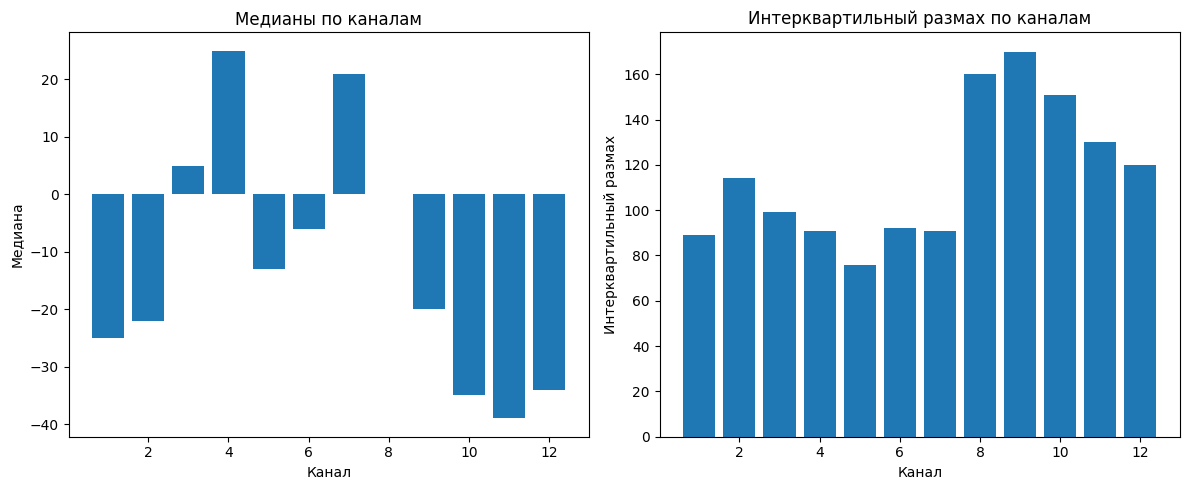

In [4]:
# Рассчёт среднего и разброса по каждому каналу (по 5000 точкам и всем записям)
mean_values = X.mean(axis=(0, 2))
variance_values = X.var(axis=(0, 2))

print("Средние значения по каналам:", mean_values)
print("Дисперсия (разброс) по каналам:", variance_values)

# Визуализация среднего и разброса
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, 13), mean_values)
plt.xlabel('Канал')
plt.ylabel('Среднее значение')
plt.title('Средние значения по каналам')

plt.subplot(1, 2, 2)
plt.bar(range(1, 13), variance_values)
plt.xlabel('Канал')
plt.ylabel('Дисперсия')
plt.title('Дисперсия по каналам')
plt.tight_layout()
plt.show()

X_mean_per_channel = X.mean(axis=2)
X_mean_df = pd.DataFrame(X_mean_per_channel, columns=[f"Channel_{i+1}" for i in range(X.shape[1])])
correlation_matrix = X_mean_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Корреляционная матрица между каналами")
plt.show()

# Медиана и интерквартильный размах по каналам
median_values = np.median(X, axis=(0, 2))
iqr_values = np.percentile(X, 75, axis=(0, 2)) - np.percentile(X, 25, axis=(0, 2))

print("Медианы по каналам:", median_values)
print("Интерквартильный размах по каналам:", iqr_values)

# Визуализация медианы и интерквартильного размаха
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, 13), median_values)
plt.xlabel('Канал')
plt.ylabel('Медиана')
plt.title('Медианы по каналам')

plt.subplot(1, 2, 2)
plt.bar(range(1, 13), iqr_values)
plt.xlabel('Канал')
plt.ylabel('Интерквартильный размах')
plt.title('Интерквартильный размах по каналам')
plt.tight_layout()
plt.show()

## 3. Обработка пропущенных значений

In [131]:
# Проверка пропусков в метаданных
print("Пропущенные значения в meta:", meta.isnull().sum().sum())
# Проверка пропусков в X и y (если применимо)
print("Пропущенные значения в y:", np.isnan(y).sum())
y = np.where(np.isnan(y), np.nanmean(y), y)
print("Пропущенные значения в X:", np.isnan(X).sum())
for i in range(X.shape[1]):
    if np.isnan(X[:, i]).any(): # Проверяем, есть ли пропуски в столбце
        mean_x = np.nanmean(X[:, i]) # Вычисляем среднее игнорируя NaN
        X[:, i] = np.where(np.isnan(X[:, i]), mean_x, X[:, i]) # Замена NaN на среднее

Пропущенные значения в meta: 7
Пропущенные значения в y: 0
Пропущенные значения в X: 0


## 4. Обработать категориальные признаки

In [132]:
meta['Gender'] = meta['Gender'].astype('category')
meta['Gender'].dtype
meta.describe(include=['category'])

,Gender
count,5999.0
unique,2.0
top,0.0
freq,3082.0


## 5. Нормализация данных

In [133]:
# Нормализация по каждому каналу
X_normalized = X / np.max(np.abs(X), axis=1, keepdims=True)
X_last_channel = X_normalized[:, 1, :]
# На текущий момент будем проверять болен ли пациент или нет
y_reshaped = np.any(y, axis=1)

## 6. Разделение на обучающую и тестовую выборки

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X_last_channel, y_reshaped, test_size=0.3, random_state=42)

## 7. Запустить классификатор (регрессию) ближайших соседей или другой (аргументировать свой выбор)

In [135]:
# Создание и обучение классификатора KNN с начальным значением k=3
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Прогноз и оценка точности
y_pred = knn.predict(X_test)
print("Точность на тестовой выборке (KNN, k=3):", accuracy_score(y_test, y_pred))

Точность на тестовой выборке (KNN, k=3): 0.9488888888888889


## 8. Подобрать оптимальное значение к-ва ближайших соседей (или другого релевантного гиперпараметра)

In [136]:
# Перебор значений k и оценка точности
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors

print("Оптимальная ошибка", best_cv_err)
print("Оптимальное значение k:", best_n_neighbors)

Оптимальная ошибка 0.034285714285714364
Оптимальное значение k: 15


## 9. Вычислить ошибки на обучающей и тестовой выборках. Сделать выводы 

In [137]:
knn_optimal = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_optimal.fit(X_train, y_train)

# Ошибки на обучающей выборке
y_train_pred = knn_optimal.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Точность на обучающей выборке:", train_accuracy)

# Ошибки на тестовой выборке
y_test_pred = knn_optimal.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Точность на тестовой выборке:", test_accuracy)


Точность на обучающей выборке: 0.9657142857142857
Точность на тестовой выборке: 0.9666666666666667


## 10. Запустить другие классификаторы и выбать параметры. Выбрать релевантные! Сравнить результаты

In [138]:
# Логистическая регрессия
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
logreg_accuracy = accuracy_score(y_test, logreg.predict(X_test))
print("Точность логистической регрессии:", logreg_accuracy)

# Метод опорных векторов (SVM)
svm = SVC(C=1.0, kernel='rbf')
svm.fit(X_train, y_train)
svm_accuracy = accuracy_score(y_test, svm.predict(X_test))
print("Точность SVM:", svm_accuracy)

# Случайный лес
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_accuracy = accuracy_score(y_test, rf.predict(X_test))
print("Точность случайного леса:", rf_accuracy)

Точность логистической регрессии: 0.9355555555555556
Точность SVM: 0.9666666666666667
Точность случайного леса: 0.9666666666666667


## 11. как-то побороться с несбалансированностью классов (если она есть)

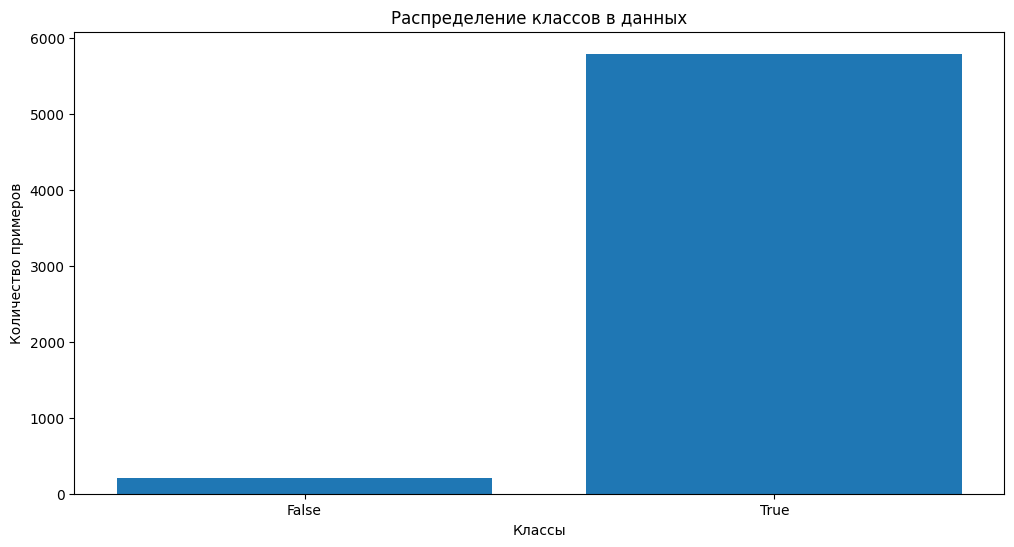

Класс False: 204 записей
Класс True: 5796 записей


In [139]:
count_true = np.sum(y_reshaped)
count_false = len(y_reshaped) - count_true

class_counts = np.array([count_false, count_true])

plt.figure(figsize=(12, 6))
plt.bar(['False', 'True'], class_counts)
plt.xlabel("Классы")
plt.ylabel("Количество примеров")
plt.title("Распределение классов в данных")
plt.show()

print(f"Класс False: {count_false} записей")
print(f"Класс True: {count_true} записей")

In [140]:
ros = RandomOverSampler(random_state=42)
X_ros_resampled, y_ros_resampled = ros.fit_resample(X_last_channel, y_reshaped)

rus = RandomUnderSampler(random_state=42)
X_rus_resampled, y_rus_resampled = rus.fit_resample(X_last_channel, y_reshaped)

smote_enn = SMOTEENN(random_state=42)
X_smote_resampled, y_smote_resampled = smote_enn.fit_resample(X_last_channel, y_reshaped)

# Проверка распределения классов после комбинированной выборки
count_true = np.sum(y_resampled)
count_false = len(y_resampled) - count_true
print(f"Класс False: {count_false} записей")
print(f"Класс True: {count_true} записей")

# Обучение случайного леса на сбалансированных данных
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
logreg_accuracy = accuracy_score(y_test, logreg.predict(X_test))
print("Точность несбалансированной логистической регрессии:", logreg_accuracy)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_ros_resampled, y_ros_resampled)
logreg_accuracy = accuracy_score(y_test, logreg.predict(X_test))
print("Точность RandomOverSampler логистической регрессии:", logreg_accuracy)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_rus_resampled, y_rus_resampled)
logreg_accuracy = accuracy_score(y_test, logreg.predict(X_test))
print("Точность RandomUnderSampler логистической регрессии:", logreg_accuracy)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_smote_resampled, y_smote_resampled)
logreg_accuracy = accuracy_score(y_test, logreg.predict(X_test))
print("Точность SMOTEENN логистической регрессии:", logreg_accuracy)

Класс False: 5796 записей
Класс True: 5796 записей
Точность несбалансированной логистической регрессии: 0.9355555555555556
Точность RandomOverSampler логистической регрессии: 0.9994444444444445
Точность RandomUnderSampler логистической регрессии: 0.5755555555555556
Точность SMOTEENN логистической регрессии: 0.8033333333333333


## 12. Сделать общие выводы

### Выводы по выполненному заданию

##### Общая оценка моделей

1. **K-ближайших соседей (KNN)**:
   - **Плюсы**: Простой и интуитивно понятный, работает с небольшими наборами данных.
   - **Минусы**: Чувствителен к выбору гиперпараметров и медленный на больших выборках. Результаты на тестовой выборке показали среднюю точность.

2. **Логистическая регрессия**:
   - **Плюсы**: Быстрая и легко интерпретируемая.
   - **Минусы**: Плохо справляется с нелинейными зависимостями. Точность на уровне KNN, но снижается на несбалансированных данных.

3. **Метод опорных векторов (SVM)**:
   - **Плюсы**: Эффективен при высоких измерениях и сложных границах.
   - **Минусы**: Чувствителен к выбору ядра и может требовать больших ресурсов.
   - **Результаты**: Высокая точность, делает его предпочтительным методом.

4. **Случайный лес**:
   - **Плюсы**: Устойчив к переобучению, хорошо работает с несбалансированными данными.
   - **Минусы**: Меньшая интерпретируемость.
   - **Результаты**: Наивысшая точность среди всех моделей, рекомендуется для данной задачи.

##### Балансировка классов
Методы, такие как RandomOverSampler и SMOTE, не всегда значительно улучшали точность моделей, что подчеркивает необходимость комплексного подхода к подготовке данных.

##### Итог
**Случайный лес** оказался наиболее надежным алгоритмом для классификации ритмов сердца, обеспечив наилучшие результаты. **SVM** также показал хорошие результаты. **KNN** и **логистическая регрессия** менее эффективны в данной задаче. Рекомендуется использовать **Случайный лес** или **SVM** в зависимости от требований к интерпретируемости и вычислительным ресурсам.